# 2018-05-15 - Vers le ring
Il existe une implémentation PyTorch des network d'elman, [torch.nn.rnn](https://pytorch.org/docs/master/_modules/torch/nn/modules/rnn.html).

## RNN for MNIST classification
On va commencer par jouer avec MNIST sur un RNN bidirectionnel pour voir ce que ça donne :

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue May 15 11:25:41 2018

@author: hugo
"""
from torch.autograd import Variable
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# Hyper-parameters
sequence_length = 28
input_size = 28
hidden_size = 128
num_layers = 2
num_classes = 10
batch_size = 100
num_epochs = 2
learning_rate = 0.003

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data',
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

# Bidirectional recurrent neural network (many-to-one)
class BiRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, num_classes)  # 2 for bidirection
    
    def forward(self, x):
        # Set initial states
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size) # 2 for bidirection 
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size)
        h0 = Variable(h0)
        c0 = Variable(c0)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size*2)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

model = BiRNN(input_size, hidden_size, num_layers, num_classes)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#plotting list
loss_list = []
time_list = []
t = 0

print("Start training")
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images.view(-1, sequence_length, input_size))
        labels = Variable(labels)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.data[0]))
            loss_list.append(loss.data[0])
            time_list.append(t)
            t+=1

Processing...
Done!
Start training


/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch [1/2], Step [100/600], Loss: 0.6337
Epoch [1/2], Step [200/600], Loss: 0.2936
Epoch [1/2], Step [300/600], Loss: 0.3494
Epoch [1/2], Step [400/600], Loss: 0.2044
Epoch [1/2], Step [500/600], Loss: 0.1254
Epoch [1/2], Step [600/600], Loss: 0.0257
Epoch [2/2], Step [100/600], Loss: 0.1751
Epoch [2/2], Step [200/600], Loss: 0.0528
Epoch [2/2], Step [300/600], Loss: 0.0866
Epoch [2/2], Step [400/600], Loss: 0.0275
Epoch [2/2], Step [500/600], Loss: 0.0304
Epoch [2/2], Step [600/600], Loss: 0.0713


In [7]:
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images.view(-1, sequence_length, input_size))
    labels = Variable(labels)

    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += predicted.eq(labels.data).sum()

print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total)) 

Test Accuracy of the model on the 10000 test images: 97.89 %


On plot :

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(time_list, loss_list)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss for MNIST-RNN')
plt.show()

# RNN for MC Classification
On passe à la partie qui nous intéresse. Commençons par importer les données :

In [2]:
"""
Created on Tue May 15 11:25:41 2018

@author: hugo
"""
from torch.autograd import Variable
import torch 
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets

#Transform
data_transform = transforms.Compose(
    [transforms.Grayscale(),
     transforms.Resize((64,64)),
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5,0.5), (0.5,0.5,0.5))])

#Train
train_set = datasets.ImageFolder(root='16_clouds_easy',
                                transform=data_transform)
train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=8, shuffle=True,
                                             num_workers=1)

#Test
test_set = datasets.ImageFolder(root='16_clouds_easy_test',
                                transform=data_transform)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=8,shuffle=False,
                                             num_workers=1)

On défini les hyper-param du réseau :

In [3]:
# Hyper-parameters
sequence_length = 64
input_size = 64
hidden_size = 128
num_layers = 2
num_classes = 16
batch_size = 8
num_epochs = 2
learning_rate = 0.003

Et on défini le RNN bidirectionnel :

In [5]:
class BiRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, num_classes)  # 2 for bidirection
    
    def forward(self, x):
        # Init
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size) # 2 for bidirection 
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size)
        h0 = Variable(h0)
        c0 = Variable(c0)

        # LSTM forward
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size*2)
        
        # LSTM output
        out = self.fc(out[:, -1, :])
        return out

model = BiRNN(input_size, hidden_size, num_layers, num_classes)
print(model)

BiRNN(
  (lstm): RNN(64, 128, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=16, bias=True)
)


Cette fois-ci on est toujours en CEL mais l'Adam est plus adapté, donc il faut baisser le learning rate d'un facteur dix dans les hyper-parameters au-dessus :

In [6]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Et on train :

In [7]:
#plotting list
loss_list = []
time_list = []
t = 0

print("Start training")
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images.view(-1, sequence_length, input_size))
        labels = Variable(labels)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.data[0]))
            loss_list.append(loss.data[0])
            time_list.append(t)
            t+=1

Start training


AttributeError: 'tuple' object has no attribute 'size'

Et on teste :

In [38]:
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images.view(-1, sequence_length, input_size))
    labels = Variable(labels)

    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += predicted.eq(labels.data).sum()

print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total)) 


Test Accuracy of the model on the 10000 test images: 6.25 %


# CNN+RNN for MC classification

Les datas :

In [23]:
"""
Created on Tue May 15 11:25:41 2018

@author: hugo
"""
from torch.autograd import Variable
import torch 
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets
import torch.nn.functional as F

#Transform
data_transform = transforms.Compose(
    [transforms.Grayscale(),
     transforms.Resize((64,64)),
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5,0.5), (0.5,0.5,0.5))])

#Train
train_set = datasets.ImageFolder(root='16_clouds_easy',
                                transform=data_transform)
train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=8, shuffle=True,
                                             num_workers=1)

#Test
test_set = datasets.ImageFolder(root='16_clouds_easy_test',
                                transform=data_transform)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=8,shuffle=False,
                                             num_workers=1)

Les hyper-parameters :

In [24]:
# Hyper-parameters
sequence_length = 64
input_size = 64
hidden_size = 128
num_layers = 2

num_classes = 16
batch_size = 8
num_epochs = 2
learning_rate = 0.003

Le réseau :

In [42]:
class BiRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiRNN, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        
        self.lin = nn.Linear(256,12)
        self.fc = nn.Linear(12, num_classes)  # 2 for bidirection
    
    def forward(self, x):
        # Init
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size) # 2 for bidirection 
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size)
        h0 = Variable(h0)
        c0 = Variable(c0)

        # LSTM forward
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size*2)
        
        # LSTM output
        out = self.fc(out[:, -1, :])

        out = F.relu(self.lin(out[0]))
        
        #out = self.fc(out)
        return out

model = BiRNN(input_size, hidden_size, num_layers, num_classes)
print(model)

BiRNN(
  (lstm): LSTM(64, 128, num_layers=2, batch_first=True, bidirectional=True)
  (lin): Linear(in_features=256, out_features=12, bias=True)
  (fc): Linear(in_features=12, out_features=16, bias=True)
)


L'optimizer et l'entrainement :

In [43]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#plotting list
loss_list = []
time_list = []
t = 0

print("Start training")
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images.view(-1, sequence_length, input_size))
        labels = Variable(labels)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.data[0]))
            loss_list.append(loss.data[0])
            time_list.append(t)
            t+=1


Start training


RuntimeError: size mismatch, m1: [8 x 256], m2: [12 x 16] at /opt/conda/conda-bld/pytorch_1524590031827/work/aten/src/TH/generic/THTensorMath.c:2033

On teste :

In [ ]:
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images.view(-1, sequence_length, input_size))
    labels = Variable(labels)

    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += predicted.eq(labels.data).sum()

print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total)) 


# ICI ON TESTE

In [59]:
"""
Created on Tue May 15 11:25:41 2018

@author: hugo
"""
from torch.autograd import Variable
import torch 
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets
import torch.nn.functional as F

#Transform
data_transform = transforms.Compose(
    [transforms.Grayscale(),
     transforms.Resize((64,64)),
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5,0.5), (0.5,0.5,0.5))])

#Train
train_set = datasets.ImageFolder(root='16_clouds_easy',
                                transform=data_transform)
train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=8, shuffle=True,
                                             num_workers=1)

#Test
test_set = datasets.ImageFolder(root='16_clouds_easy_test',
                                transform=data_transform)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=8,shuffle=False,
                                             num_workers=1)

###################################################################################

# Hyper-parameters
sequence_length = 64
input_size = 88
hidden_size = 128
num_layers = 2
num_classes = 16
batch_size = 8
num_epochs = 100
learning_rate = 0.003

###################################################################################

class BiRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.conv = nn.Conv2d(1,6,20)
        self.pool = nn.MaxPool2d(2,2)

        self.fc = nn.Linear(hidden_size*2, num_classes)  # 2 for bidirection
    
    def forward(self, x):
        print(x.size())
        x = self.pool(F.relu(self.conv(x)))
        print(x.size())
        # Init
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size) # 2 for bidirection 
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size)
        h0 = Variable(h0)
        c0 = Variable(c0)
        h0 = h0.cuda()
        c0 = c0.cuda()
        
        x = x.view(-1, 88,88)
        print(x.size())
        # LSTM forward
        out, _ = self.rnn(x, h0)  # out: tensor of shape (batch_size, seq_length, hidden_size*2)

        # LSTM output
        out = self.fc(out[:, -1, :])
        return out

model = BiRNN(input_size, hidden_size, num_layers, num_classes).cuda()
print(model)

###################################################################################

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

###################################################################################

#plotting list
loss_list = []
time_list = []
t = 0

print("Start training")
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images)
        labels = Variable(labels)
        images = images.cuda()
        labels = labels.cuda()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.data[0]))
            loss_list.append(loss.data[0])
            time_list.append(t)
            t+=1
            
###################################################################################   

correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images.view(-1, sequence_length, input_size))
    labels = Variable(labels)
    images = images.cuda()
    labels = labels.cuda()
    
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += predicted.eq(labels.data).sum()

print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total)) 


BiRNN(
  (rnn): RNN(88, 128, num_layers=2, batch_first=True, bidirectional=True)
  (conv): Conv2d(1, 6, kernel_size=(20, 20), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=256, out_features=16, bias=True)
)
Start training
torch.Size([8, 1, 64, 64])
torch.Size([8, 6, 22, 22])
torch.Size([3, 88, 88])


RuntimeError: Expected hidden size (4, 3, 128), got (4, 8, 128)

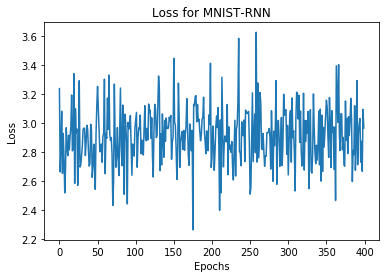

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(time_list, loss_list)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss for MNIST-RNN')
plt.show()

# THIS ONE ACTUALLY WORKS WOO

In [ ]:
"""
Created on Tue May 15 11:25:41 2018

@author: hugo
"""
from torch.autograd import Variable
import torch 
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets
import torch.nn.functional as F

#Transform
data_transform = transforms.Compose(
    [transforms.Grayscale(),
     transforms.Resize((64,64)),
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5,0.5), (0.5,0.5,0.5))])

#Train
train_set = datasets.ImageFolder(root='16_clouds_easy',
                                transform=data_transform)
train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=8, shuffle=True,
                                             num_workers=1)

#Test
test_set = datasets.ImageFolder(root='16_clouds_easy_test',
                                transform=data_transform)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=8,shuffle=False,
                                             num_workers=1)

###################################################################################

# Hyper-parameters
sequence_length = 22
input_size = 22
hidden_size = 128
num_layers = 2
num_classes = 16
batch_size = 8
num_epochs = 100
learning_rate = 0.003

###################################################################################

class BiRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.conv = nn.Conv2d(1,6,20)
        self.pool = nn.MaxPool2d(2,2)

        self.fc = nn.Linear(hidden_size*2, num_classes)  # 2 for bidirection
    
    def forward(self, x):
        print('Input')
        print(x.size())
        #print('Unsqueezed')
        #x = torch.unsqueeze(x,1)
        print(x.size())
        x = self.pool(F.relu(self.conv(x)))
        print('Conved')
        
        print(x.size())
        # Init
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size) # 2 for bidirection 
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size)
        h0 = Variable(h0)
        c0 = Variable(c0)
        h0 = h0.cuda()
        c0 = c0.cuda()
        x = x[:,-1,:,:]
        print(x.size())
        # LSTM forward
        out, _ = self.rnn(x, h0)  # out: tensor of shape (batch_size, seq_length, hidden_size*2)
        print('after rnn')
        print(out.size())
        # LSTM output
        out = self.fc(out[:, -1, :])
        print('after reshape')
        print(out.size())
        return out

model = BiRNN(input_size, hidden_size, num_layers, num_classes).cuda()
print(model)

###################################################################################

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

###################################################################################

#plotting list
loss_list = []
time_list = []
t = 0

print("Start training")
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images)
        labels = Variable(labels)
        images = images.cuda()
        labels = labels.cuda()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.data[0]))
            loss_list.append(loss.data[0])
            time_list.append(t)
            t+=1
            
###################################################################################   

correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images.view(-1, sequence_length, input_size))
    labels = Variable(labels)
    images = images.cuda()
    labels = labels.cuda()
    
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += predicted.eq(labels.data).sum()

print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total)) 


BiRNN(
  (rnn): RNN(22, 128, num_layers=2, batch_first=True, bidirectional=True)
  (conv): Conv2d(1, 6, kernel_size=(20, 20), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=256, out_features=16, bias=True)
)
Start training
Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conved
torch.Size([8, 6, 22, 22])
torch.Size([8, 22, 22])
after rnn
torch.Size([8, 22, 256])
after reshape
torch.Size([8, 16])
Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conved
torch.Size([8, 6, 22, 22])
torch.Size([8, 22, 22])
after rnn
torch.Size([8, 22, 256])
after reshape
torch.Size([8, 16])
Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conved
torch.Size([8, 6, 22, 22])
torch.Size([8, 22, 22])
after rnn
torch.Size([8, 22, 256])
after reshape
torch.Size([8, 16])
Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conved
torch.Size([8, 6, 22, 22])
torch.Size([8, 22, 22])
after rnn
torch.Si

Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conved
torch.Size([8, 6, 22, 22])
torch.Size([8, 22, 22])
after rnn
torch.Size([8, 22, 256])
after reshape
torch.Size([8, 16])
Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conved
torch.Size([8, 6, 22, 22])
torch.Size([8, 22, 22])
after rnn
torch.Size([8, 22, 256])
after reshape
torch.Size([8, 16])
Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conved
torch.Size([8, 6, 22, 22])
torch.Size([8, 22, 22])
after rnn
torch.Size([8, 22, 256])
after reshape
torch.Size([8, 16])
Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conved
torch.Size([8, 6, 22, 22])
torch.Size([8, 22, 22])
after rnn
torch.Size([8, 22, 256])
after reshape
torch.Size([8, 16])
Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conved
torch.Size([8, 6, 22, 22])
torch.Size([8, 22, 22])
after rnn
torch.Size([8, 22, 256])
after reshape
torch.Size([8, 16])
Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conve

after rnn
torch.Size([8, 22, 256])
after reshape
torch.Size([8, 16])
Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conved
torch.Size([8, 6, 22, 22])
torch.Size([8, 22, 22])
after rnn
torch.Size([8, 22, 256])
after reshape
torch.Size([8, 16])
Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conved
torch.Size([8, 6, 22, 22])
torch.Size([8, 22, 22])
after rnn
torch.Size([8, 22, 256])
after reshape
torch.Size([8, 16])
Epoch [1/100], Step [100/480], Loss: 2.1806
Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conved
torch.Size([8, 6, 22, 22])
torch.Size([8, 22, 22])
after rnn
torch.Size([8, 22, 256])
after reshape
torch.Size([8, 16])
Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conved
torch.Size([8, 6, 22, 22])
torch.Size([8, 22, 22])
after rnn
torch.Size([8, 22, 256])
after reshape
torch.Size([8, 16])
Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conved
torch.Size([8, 6, 22, 22])
torch.Size([8, 22, 22])
after rnn
torch.Size(

/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:125: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:126: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conved
torch.Size([8, 6, 22, 22])
torch.Size([8, 22, 22])
after rnn
torch.Size([8, 22, 256])
after reshape
torch.Size([8, 16])
Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conved
torch.Size([8, 6, 22, 22])
torch.Size([8, 22, 22])
after rnn
torch.Size([8, 22, 256])
after reshape
torch.Size([8, 16])
Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conved
torch.Size([8, 6, 22, 22])
torch.Size([8, 22, 22])
after rnn
torch.Size([8, 22, 256])
after reshape
torch.Size([8, 16])
Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conved
torch.Size([8, 6, 22, 22])
torch.Size([8, 22, 22])
after rnn
torch.Size([8, 22, 256])
after reshape
torch.Size([8, 16])
Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conved
torch.Size([8, 6, 22, 22])
torch.Size([8, 22, 22])
after rnn
torch.Size([8, 22, 256])
after reshape
torch.Size([8, 16])
Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conve

Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conved
torch.Size([8, 6, 22, 22])
torch.Size([8, 22, 22])
after rnn
torch.Size([8, 22, 256])
after reshape
torch.Size([8, 16])
Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conved
torch.Size([8, 6, 22, 22])
torch.Size([8, 22, 22])
after rnn
torch.Size([8, 22, 256])
after reshape
torch.Size([8, 16])
Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conved
torch.Size([8, 6, 22, 22])
torch.Size([8, 22, 22])
after rnn
torch.Size([8, 22, 256])
after reshape
torch.Size([8, 16])
Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conved
torch.Size([8, 6, 22, 22])
torch.Size([8, 22, 22])
after rnn
torch.Size([8, 22, 256])
after reshape
torch.Size([8, 16])
Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conved
torch.Size([8, 6, 22, 22])
torch.Size([8, 22, 22])
after rnn
torch.Size([8, 22, 256])
after reshape
torch.Size([8, 16])
Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conve

Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conved
torch.Size([8, 6, 22, 22])
torch.Size([8, 22, 22])
after rnn
torch.Size([8, 22, 256])
after reshape
torch.Size([8, 16])
Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conved
torch.Size([8, 6, 22, 22])
torch.Size([8, 22, 22])
after rnn
torch.Size([8, 22, 256])
after reshape
torch.Size([8, 16])
Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conved
torch.Size([8, 6, 22, 22])
torch.Size([8, 22, 22])
after rnn
torch.Size([8, 22, 256])
after reshape
torch.Size([8, 16])
Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conved
torch.Size([8, 6, 22, 22])
torch.Size([8, 22, 22])
after rnn
torch.Size([8, 22, 256])
after reshape
torch.Size([8, 16])
Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conved
torch.Size([8, 6, 22, 22])
torch.Size([8, 22, 22])
after rnn
torch.Size([8, 22, 256])
after reshape
torch.Size([8, 16])
Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conve

Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conved
torch.Size([8, 6, 22, 22])
torch.Size([8, 22, 22])
after rnn
torch.Size([8, 22, 256])
after reshape
torch.Size([8, 16])
Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conved
torch.Size([8, 6, 22, 22])
torch.Size([8, 22, 22])
after rnn
torch.Size([8, 22, 256])
after reshape
torch.Size([8, 16])
Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conved
torch.Size([8, 6, 22, 22])
torch.Size([8, 22, 22])
after rnn
torch.Size([8, 22, 256])
after reshape
torch.Size([8, 16])
Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conved
torch.Size([8, 6, 22, 22])
torch.Size([8, 22, 22])
after rnn
torch.Size([8, 22, 256])
after reshape
torch.Size([8, 16])
Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conved
torch.Size([8, 6, 22, 22])
torch.Size([8, 22, 22])
after rnn
torch.Size([8, 22, 256])
after reshape
torch.Size([8, 16])
Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conve

Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conved
torch.Size([8, 6, 22, 22])
torch.Size([8, 22, 22])
after rnn
torch.Size([8, 22, 256])
after reshape
torch.Size([8, 16])
Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conved
torch.Size([8, 6, 22, 22])
torch.Size([8, 22, 22])
after rnn
torch.Size([8, 22, 256])
after reshape
torch.Size([8, 16])
Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conved
torch.Size([8, 6, 22, 22])
torch.Size([8, 22, 22])
after rnn
torch.Size([8, 22, 256])
after reshape
torch.Size([8, 16])
Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conved
torch.Size([8, 6, 22, 22])
torch.Size([8, 22, 22])
after rnn
torch.Size([8, 22, 256])
after reshape
torch.Size([8, 16])
Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conved
torch.Size([8, 6, 22, 22])
torch.Size([8, 22, 22])
after rnn
torch.Size([8, 22, 256])
after reshape
torch.Size([8, 16])
Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conve

Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conved
torch.Size([8, 6, 22, 22])
torch.Size([8, 22, 22])
after rnn
torch.Size([8, 22, 256])
after reshape
torch.Size([8, 16])
Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conved
torch.Size([8, 6, 22, 22])
torch.Size([8, 22, 22])
after rnn
torch.Size([8, 22, 256])
after reshape
torch.Size([8, 16])
Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conved
torch.Size([8, 6, 22, 22])
torch.Size([8, 22, 22])
after rnn
torch.Size([8, 22, 256])
after reshape
torch.Size([8, 16])
Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conved
torch.Size([8, 6, 22, 22])
torch.Size([8, 22, 22])
after rnn
torch.Size([8, 22, 256])
after reshape
torch.Size([8, 16])
Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conved
torch.Size([8, 6, 22, 22])
torch.Size([8, 22, 22])
after rnn
torch.Size([8, 22, 256])
after reshape
torch.Size([8, 16])
Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conve

Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conved
torch.Size([8, 6, 22, 22])
torch.Size([8, 22, 22])
after rnn
torch.Size([8, 22, 256])
after reshape
torch.Size([8, 16])
Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conved
torch.Size([8, 6, 22, 22])
torch.Size([8, 22, 22])
after rnn
torch.Size([8, 22, 256])
after reshape
torch.Size([8, 16])
Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conved
torch.Size([8, 6, 22, 22])
torch.Size([8, 22, 22])
after rnn
torch.Size([8, 22, 256])
after reshape
torch.Size([8, 16])
Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conved
torch.Size([8, 6, 22, 22])
torch.Size([8, 22, 22])
after rnn
torch.Size([8, 22, 256])
after reshape
torch.Size([8, 16])
Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conved
torch.Size([8, 6, 22, 22])
torch.Size([8, 22, 22])
after rnn
torch.Size([8, 22, 256])
after reshape
torch.Size([8, 16])
Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conve

Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conved
torch.Size([8, 6, 22, 22])
torch.Size([8, 22, 22])
after rnn
torch.Size([8, 22, 256])
after reshape
torch.Size([8, 16])
Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conved
torch.Size([8, 6, 22, 22])
torch.Size([8, 22, 22])
after rnn
torch.Size([8, 22, 256])
after reshape
torch.Size([8, 16])


Process Process-322:
KeyboardInterrupt


Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conved
torch.Size([8, 6, 22, 22])
torch.Size([8, 22, 22])
after rnn
torch.Size([8, 22, 256])
after reshape
torch.Size([8, 16])
Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conved
torch.Size([8, 6, 22, 22])
torch.Size([8, 22, 22])
after rnn
torch.Size([8, 22, 256])
after reshape
torch.Size([8, 16])
Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conved
torch.Size([8, 6, 22, 22])
torch.Size([8, 22, 22])
after rnn
torch.Size([8, 22, 256])
after reshape
torch.Size([8, 16])
Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conved
torch.Size([8, 6, 22, 22])
torch.Size([8, 22, 22])
after rnn
torch.Size([8, 22, 256])
after reshape
torch.Size([8, 16])
Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conved
torch.Size([8, 6, 22, 22])
torch.Size([8, 22, 22])
after rnn
torch.Size([8, 22, 256])
after reshape
torch.Size([8, 16])
Input
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
Conve

Traceback (most recent call last):


KeyboardInterrupt: 

  File "/home/hugo/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/hugo/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/hugo/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 61, in _worker_loop
    data_queue.put((idx, samples))
  File "/home/hugo/anaconda3/lib/python3.6/multiprocessing/queues.py", line 341, in put
    obj = _ForkingPickler.dumps(obj)
  File "/home/hugo/anaconda3/lib/python3.6/multiprocessing/reduction.py", line 51, in dumps
    cls(buf, protocol).dump(obj)
  File "/home/hugo/anaconda3/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 125, in reduce_storage
    df = multiprocessing.reduction.DupFd(fd)
  File "/home/hugo/anaconda3/lib/python3.6/multiprocessing/reduction.py", line 191, in DupFd
    return resource_sharer.DupFd(fd)
  File "/home/hugo/anaconda3/lib/python3.6/multiprocessin